# 📑 &nbsp; Deep Learning. P2: Multi-Label Classification. Letter Recognition
<a href="https://olgabelitskaya.github.io/README.html">&#x1F300; &nbsp; Home Page &nbsp; &nbsp; &nbsp;</a>
<a href="https://www.instagram.com/olga.belitskaya/">&#x1F300; &nbsp; Instagram Posts &nbsp; &nbsp; &nbsp;</a>
<a href="https://www.pinterest.ru/olga_belitskaya/code-style/">&#x1F300; &nbsp; Pinterest Posts</a><br/>
For this project, I have created the dataset of <br/>
14190 color images (32x32x3) with 33 symbols of handwritten Russian letters.<br/>
There are four types of letter backgrounds here.<br/>
They are labeled in this dataset as well.<br/>

In [1]:
from IPython import display
display.HTML("""<style>
@import url('https://fonts.googleapis.com/css?family=Akronim|Ruthie');
</style><div id='im'>
<table style='width:30%; background-color:ghostwhite; 
      font-family:Ruthie; font-size:200%;'>
<tr style='font-family:Akronim;'><th><center>Background</center></th>
<th><center>Image</center></th></tr>
<tr><td><center>0</center></td><td><center>
<img width='50' height='50' 
src='https://olgabelitskaya.github.io/images/03_16.jpeg' alt='bg0'>
</center></td></tr><tr><td><center>1</center></td><td><center>
<img width='50' height='50' 
src='https://olgabelitskaya.github.io/images/08_50.jpeg' alt='bg1'>
</center></td></tr><tr><td><center>2</center></td><td><center>
<img width='50' height='50' 
src='https://olgabelitskaya.github.io/images/11_216.jpeg' alt='bg2'>
</center></td></tr><tr><td><center>3</center></td><td><center>
<img width='50' height='50' 
src='https://olgabelitskaya.github.io/images/20_415.jpeg' alt='bg3'>
</center></td></tr></table></div>""")

Background,Image
0,
1,
2,
3,


## ✒️ &nbsp; Step 0. Importing Libraries and Defining Helpful Functions

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import h5py,urllib,zipfile
import pandas as pd,numpy as np,pylab as pl
import keras as ks,tensorflow as tf
import warnings; warnings.filterwarnings('ignore')
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
i0,i1,i2,i3,i4,i5=int(0),int(1),int(2),int(3),int(4),int(5)
np.set_printoptions(precision=6)
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:', tf.__version__)

Using TensorFlow backend.


keras version: 2.3.1
tensorflow version: 1.15.2


In [0]:
#from keras.preprocessing import image as keras_image
#from keras import backend,losses
#from keras.engine.topology import Layer
#from keras.optimizers import Adam,Nadam
#from keras.engine import InputLayer
#from keras.layers import Dense, LSTM, Activation, LeakyReLU
#from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, GlobalMaxPooling2D
#from keras.layers import UpSampling2D, Conv2DTranspose
#from keras.layers.core import RepeatVector, Permute
#from keras.layers import Reshape, concatenate, merge

In [0]:
def ohe(x): 
    return OneHotEncoder(categories='auto')\
           .fit(x.reshape(-i1,i1))\
           .transform(x.reshape(-i1,i1))\
           .toarray().astype('int64')
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=float(.2),
                     random_state=i1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test
def resh(x):
    y=[resize(el,(int(24),int(24),int(3)),
              anti_aliasing=True) for el in x]
    return np.array(y)
def resh2(x): 
    return x.reshape(-int(1),int(32),int(32),int(1))

In [0]:
def history_plot(fit_history):
    pl.figure(figsize=(12,10))
    pl.subplot(211)
    pl.plot(fit_history.history['loss'],
            color='slategray',label='train')
    pl.plot(fit_history.history['val_loss'],
            color='#348ABD',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history['accuracy'],
            color='slategray',label='train')
    pl.plot(fit_history.history['val_accuracy'],
            color='#348ABD',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()

 ## ✒️ &nbsp;Step 1. Loading and Preprocessing the Data

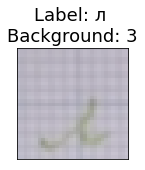

In [7]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb')
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys())
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
backgrounds=np.array(f[keys[0]])
images=np.array(f[keys[1]])/255
labels=np.array(f[keys[2]])
pl.figure(figsize=(2,3)); il=10**4
pl.xticks([]); pl.yticks([])
pl.title('Label: %s \n'%letters[labels[il]-1]+\
         'Background: %s'%backgrounds[il],
         fontsize=18)
pl.imshow(images[il]); pl.show()

In [8]:
images.shape

(14190, 32, 32, 3)

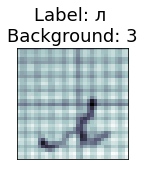

In [9]:
gray_images=np.dot(images[...,:3],[.299,.587,.114])
pl.figure(figsize=(2,3))
pl.title('Label: %s \n'%letters[labels[il]-1]+\
         'Background: %s'%backgrounds[il],
         fontsize=18)
pl.imshow(gray_images[il],cmap=pl.cm.bone)
pl.xticks([]); pl.yticks([]); pl.show()

In [10]:
cbackgrounds,clabels=ohe(backgrounds),ohe(labels)
pd.DataFrame([labels[97:103],clabels[97:103]]).T

,0,1
0,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [11]:
ctargets=\
np.concatenate((clabels,cbackgrounds),axis=1)
pd.DataFrame([clabels.shape,cbackgrounds.shape,
              ctargets.shape])

,0,1
0,14190,33
1,14190,4
2,14190,37


In [12]:
x_train1,x_valid1,x_test1,\
y_train1,y_valid1,y_test1=tts(images,clabels)
x_train2,x_valid2,x_test2,\
y_train2,y_valid2,y_test2=tts(gray_images,clabels)
x_train3,x_valid3,x_test3,\
y_train3,y_valid3,y_test3=tts(images,ctargets)
x_train4,x_valid4,x_test4,\
y_train4,y_valid4,y_test4=tts(gray_images,ctargets)
x_train2,x_valid2,x_test2=\
resh2(x_train2),resh2(x_valid2),resh2(x_test2)
x_train4,x_valid4,x_test4=\
resh2(x_train4),resh2(x_valid4),resh2(x_test4)
sh=[el.shape for el in \
[x_train1,y_train1,x_valid1,y_valid1,x_test1,y_test1,
 x_train2,y_train2,x_valid2,y_valid2,x_test2,y_test2,
 x_train3,y_train3,x_valid3,y_valid3,x_test3,y_test3,
 x_train4,y_train4,x_valid4,y_valid4,x_test4,y_test4]]
pd.DataFrame(sh)

,0,1,2,3
0,11352,32,32.0,3.0
1,11352,33,NaN,NaN
2,1419,32,32.0,3.0
3,1419,33,NaN,NaN
4,1419,32,32.0,3.0
5,1419,33,NaN,NaN
6,11352,32,32.0,1.0
7,11352,33,NaN,NaN
8,1419,32,32.0,1.0
9,1419,33,NaN,NaN


In [0]:
fw='weights.letter.hdf5'
dr,fr,al=float(.2),float(.2),float(.02)
i10,i16,i32,i33=int(10),int(16),int(32),int(33)
i48,i64,i96=int(48),int(64),int(96)
i100,i128,i196,i200=int(100),int(128),int(196),int(200)
i256,i512,i1024=int(256),int(512),int(1024)
n1,n2=int(3000),int(500)

In [0]:
rx_train1,rx_valid1,rx_test1=\
resh(x_train1),resh(x_valid1),resh(x_test1)

## ✒️ &nbsp; Step 2. One-Label Classification Models
#### Color Images

In [16]:
def model():
    model=Sequential()
    model.add(Dense(128,input_shape=(32*32*3,)))
    model.add(LeakyReLU(alpha=.2)) 
    model.add(BatchNormalization())
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.2))
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.2))
    model.add(BatchNormalization())
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=.2))   
    model.add(Dropout(.2))    
    model.add(Dense(33))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
model=model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,
                             save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',
                        patience=32,verbose=2)
history=model.fit(x_train1.reshape(-1,32*32*3),y_train1,epochs=200,batch_size=128,
                  verbose=2,validation_data=(x_valid1.reshape(-1,32*32*3),y_valid1),
                  callbacks=[checkpointer,lr_reduction,estopping])


Train on 11352 samples, validate on 1419 samples
Epoch 1/200
 - 3s - loss: 2.7190 - accuracy: 0.2437 - val_loss: 4.8172 - val_accuracy: 0.0458

Epoch 00001: val_loss improved from inf to 4.81721, saving model to weights.letter.hdf5
Epoch 2/200
 - 1s - loss: 2.1449 - accuracy: 0.3841 - val_loss: 7.9996 - val_accuracy: 0.0641

Epoch 00002: val_loss did not improve from 4.81721
Epoch 3/200
 - 1s - loss: 1.8949 - accuracy: 0.4486 - val_loss: 14.2076 - val_accuracy: 0.0634

Epoch 00003: val_loss did not improve from 4.81721
Epoch 4/200
 - 1s - loss: 1.7222 - accuracy: 0.4959 - val_loss: 13.6963 - val_accuracy: 0.0331

Epoch 00004: val_loss did not improve from 4.81721
Epoch 5/200
 - 1s - loss: 1.6084 - accuracy: 0.5203 - val_loss: 17.0335 - val_accuracy: 0.0564

Epoch 00005: val_loss did not improve from 4.81721
Epoch 6/200
 - 1s - loss: 1.4299 - accuracy: 0.5692 - val_loss: 6.9597 - val_accuracy: 0.0994

Epoch 00006: val_loss did not improve from 4.81721

Epoch 00006: ReduceLROnPlateau re

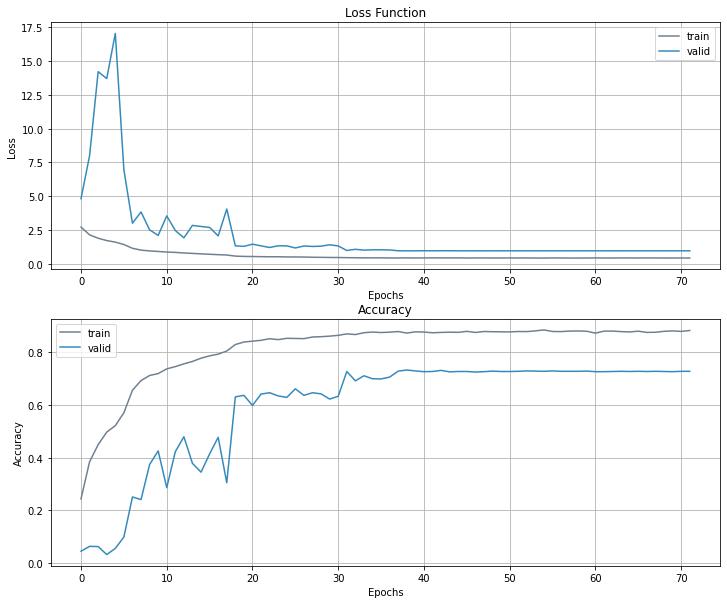

1419/1419 [==============================] - 0s 78us/step


[1.0103581817827232, 0.7145877480506897]

In [20]:
history_plot(history)
model.load_weights(fw)
model.evaluate(x_test1.reshape(-1,32*32*3),y_test1)

In [0]:
"""
RNN
def model():
    model=Sequential()
    
    model.add(BatchNormalization())
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=.2))   
    model.add(Dropout(.2))    
    model.add(Dense(33))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
model=model()
"""

In [0]:
def model():
    model=Sequential()
    model.add(Conv2D(i16,(i3,i3),padding='same', 
                     input_shape=rx_train1.shape[i1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr))
    model.add(Conv2D(i48,(i3,i3)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr))    
    model.add(GlobalMaxPooling2D())     
    model.add(Dense(i512,activation='relu'))
    model.add(Dropout(dr))    
    model.add(Dense(i33,activation='softmax'))   
    model.compile(loss='categorical_crossentropy', 
                  optimizer='nadam',metrics=['accuracy'])   
    return model
model=model()    

In [0]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,
                             save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
estopping=EarlyStopping(monitor='val_loss',
                        patience=i32,verbose=i2)
history=model.fit(rx_train1,y_train1,epochs=i200,batch_size=i128,
                  verbose=i2,validation_data=(rx_valid1,y_valid1),
                  callbacks=[checkpointer,lr_reduction,estopping])

Train on 11352 samples, validate on 1419 samples
Epoch 1/200
 - 4s - loss: 3.4855 - acc: 0.0338 - val_loss: 3.4699 - val_acc: 0.0486

Epoch 00001: val_loss improved from inf to 3.46993, saving model to weights.letter.hdf5
Epoch 2/200
 - 1s - loss: 3.4114 - acc: 0.0521 - val_loss: 3.3769 - val_acc: 0.0514

Epoch 00002: val_loss improved from 3.46993 to 3.37692, saving model to weights.letter.hdf5
Epoch 3/200
 - 1s - loss: 3.3582 - acc: 0.0644 - val_loss: 3.3704 - val_acc: 0.0627

Epoch 00003: val_loss improved from 3.37692 to 3.37045, saving model to weights.letter.hdf5
Epoch 4/200
 - 1s - loss: 3.3209 - acc: 0.0667 - val_loss: 3.4209 - val_acc: 0.0550

Epoch 00004: val_loss did not improve from 3.37045
Epoch 5/200
 - 1s - loss: 3.2738 - acc: 0.0741 - val_loss: 3.2891 - val_acc: 0.0810

Epoch 00005: val_loss improved from 3.37045 to 3.28912, saving model to weights.letter.hdf5
Epoch 6/200
 - 1s - loss: 3.2209 - acc: 0.0842 - val_loss: 3.2648 - val_acc: 0.0677

Epoch 00006: val_loss impr

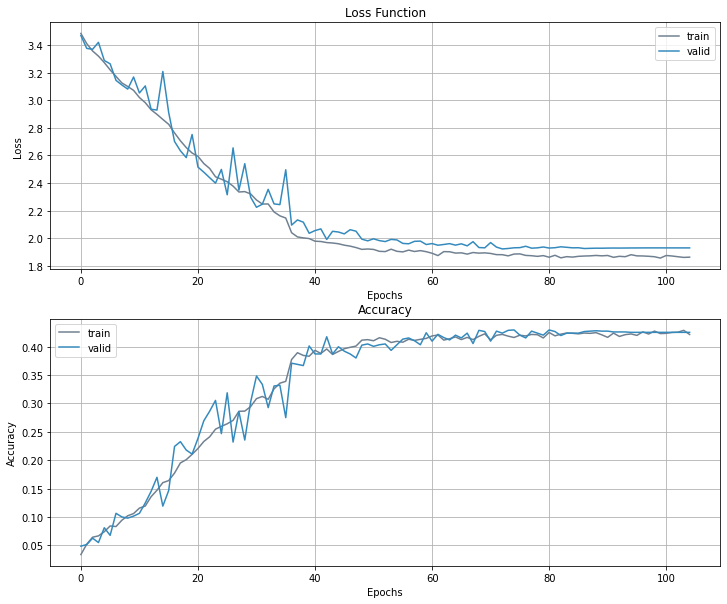

1419/1419 [==============================] - 0s 73us/step


[1.9085240747997507, 0.42988019740606714]

In [0]:
history_plot(history)
model.load_weights(fw)
model.evaluate(rx_test1,y_test1)

In [0]:
def model():
    model=Sequential()
    model.add(Conv2D(i32,(i5,i5),padding='same',
                     input_shape=x_train1.shape[i1:]))
    model.add(LeakyReLU(alpha=al))   
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr))
    model.add(Conv2D(i196,(i5,i5)))
    model.add(LeakyReLU(alpha=al))  
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr))
    model.add(GlobalMaxPooling2D())  
    model.add(Dense(i1024))
    model.add(LeakyReLU(alpha=al))
    model.add(Dropout(2*dr))     
    model.add(Dense(i33,activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])   
    return model
model=model()

In [0]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,
                             save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
estopping=EarlyStopping(monitor='val_loss',patience=i32,verbose=i2)
history=model.fit(x_train1,y_train1,epochs=i200,batch_size=i64,
                  verbose=i2,validation_data=(x_valid1,y_valid1),
                  callbacks=[checkpointer,lr_reduction,estopping])

Train on 11352 samples, validate on 1419 samples
Epoch 1/200
 - 5s - loss: 3.4724 - acc: 0.0418 - val_loss: 3.4091 - val_acc: 0.0634

Epoch 00001: val_loss improved from inf to 3.40910, saving model to weights.letter.hdf5
Epoch 2/200
 - 2s - loss: 3.3355 - acc: 0.0683 - val_loss: 3.3577 - val_acc: 0.0719

Epoch 00002: val_loss improved from 3.40910 to 3.35770, saving model to weights.letter.hdf5
Epoch 3/200
 - 2s - loss: 3.2226 - acc: 0.0780 - val_loss: 3.1779 - val_acc: 0.0789

Epoch 00003: val_loss improved from 3.35770 to 3.17791, saving model to weights.letter.hdf5
Epoch 4/200
 - 2s - loss: 3.1516 - acc: 0.0803 - val_loss: 3.1221 - val_acc: 0.1008

Epoch 00004: val_loss improved from 3.17791 to 3.12214, saving model to weights.letter.hdf5
Epoch 5/200
 - 2s - loss: 3.1228 - acc: 0.0866 - val_loss: 3.0772 - val_acc: 0.0937

Epoch 00005: val_loss improved from 3.12214 to 3.07721, saving model to weights.letter.hdf5
Epoch 6/200
 - 2s - loss: 3.0663 - acc: 0.0995 - val_loss: 3.0635 - va

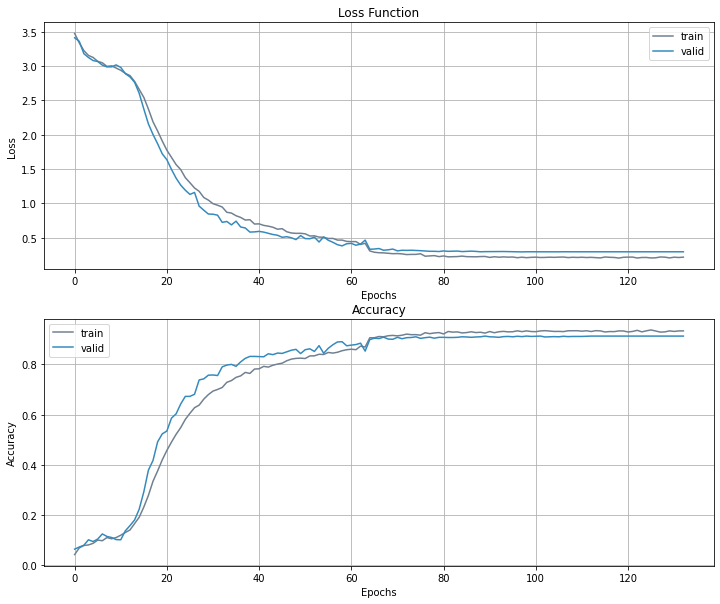

1419/1419 [==============================] - 0s 105us/step


[0.2794563175822917, 0.9154334038054969]

In [0]:
history_plot(history)
model.load_weights(fw)
model.evaluate(x_test1,y_test1)

In [0]:
steps,epochs=int(1000),int(10)
zr,sr,rr=float(.2),float(.2),int(2)
igen=ImageDataGenerator(zoom_range=zr,shear_range=sr,rotation_range=rr)
generator=model.fit_generator(igen.flow(x_train1,y_train1,batch_size=i64),
                              steps_per_epoch=steps,epochs=epochs,verbose=i2,
                              validation_data=(x_valid1,y_valid1), 
                              callbacks=[checkpointer,lr_reduction])

Epoch 1/10
 - 27s - loss: 0.4132 - acc: 0.8706 - val_loss: 0.2903 - val_acc: 0.9119

Epoch 00001: val_loss improved from 0.29026 to 0.29026, saving model to weights.letter.hdf5
Epoch 2/10
 - 27s - loss: 0.4166 - acc: 0.8694 - val_loss: 0.2903 - val_acc: 0.9119

Epoch 00002: val_loss improved from 0.29026 to 0.29026, saving model to weights.letter.hdf5
Epoch 3/10
 - 27s - loss: 0.4137 - acc: 0.8705 - val_loss: 0.2903 - val_acc: 0.9119

Epoch 00003: val_loss did not improve from 0.29026
Epoch 4/10
 - 27s - loss: 0.4212 - acc: 0.8672 - val_loss: 0.2903 - val_acc: 0.9119

Epoch 00004: val_loss did not improve from 0.29026
Epoch 5/10
 - 27s - loss: 0.4131 - acc: 0.8682 - val_loss: 0.2903 - val_acc: 0.9119

Epoch 00005: val_loss improved from 0.29026 to 0.29026, saving model to weights.letter.hdf5
Epoch 6/10
 - 27s - loss: 0.4125 - acc: 0.8691 - val_loss: 0.2903 - val_acc: 0.9119

Epoch 00006: val_loss improved from 0.29026 to 0.29026, saving model to weights.letter.hdf5

Epoch 00006: Reduce

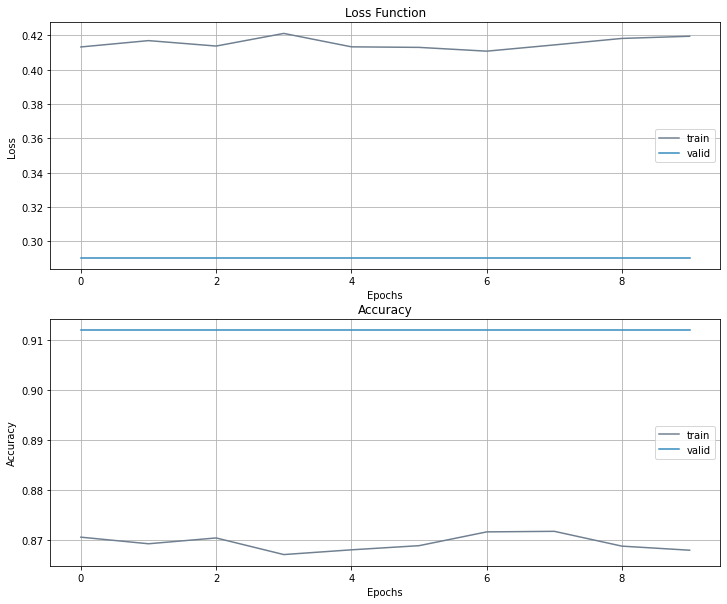

1419/1419 [==============================] - 0s 102us/step


[0.27945618180215487, 0.9154334038054969]

In [0]:
history_plot(generator)
model.load_weights(fw)
model.evaluate(x_test1,y_test1)

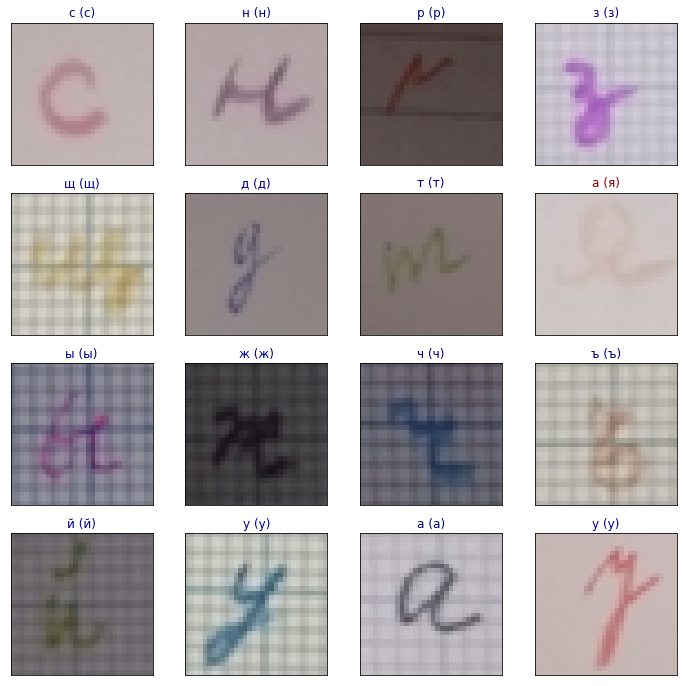

In [0]:
py_test1=model.predict_classes(x_test1)
fig=pl.figure(figsize=(12,12))
for i,idx in enumerate(np.random.choice(x_test1.shape[0],
                                        size=16,replace=False)):
    ax=fig.add_subplot(4,4,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test1[idx]))
    pred_idx=py_test1[idx]
    true_idx=np.argmax(y_test1[idx])
    ax.set_title("{} ({})".format(letters[pred_idx],letters[true_idx]),
                 color=("darkblue" if pred_idx==true_idx else "darkred"))

In [0]:
cy_train1=np.array([np.argmax(y) for y in y_train1])
cy_test1=np.array([np.argmax(y) for y in y_test1])
cy_valid1=np.array([np.argmax(y) for y in y_valid1])

In [0]:
# clf1=GradientBoostingClassifier()\
# .fit(x_train1.reshape(-1,32*32*3),cy_train1)
# [clf1.score(x_test1.reshape(-1,32*32*3),cy_test1),
#  clf1.score(x_valid1.reshape(-1,32*32*3),cy_valid1)]

In [0]:
clf2=RandomForestClassifier()\
.fit(x_train1.reshape(-1,32*32*3),cy_train1)
[clf2.score(x_test1.reshape(-1,32*32*3),cy_test1),
 clf2.score(x_valid1.reshape(-1,32*32*3),cy_valid1)]

[0.39464411557434814, 0.3981677237491191]

#### Grayscale Images

In [0]:
def gray_model():
    model=Sequential()    
    model.add(Conv2D(i32,(i5,i5),padding='same', 
                     input_shape=x_train2.shape[i1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr))
    model.add(Conv2D(i256, (i5,i5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr))   
    model.add(GlobalMaxPooling2D())    
    model.add(Dense(i1024,activation='relu'))
    model.add(Dropout(dr))     
    model.add(Dense(i256,activation='relu'))
    model.add(Dropout(dr))    
    model.add(Dense(i33,activation='softmax'))   
    model.compile(loss='categorical_crossentropy', 
                  optimizer='rmsprop',metrics=['accuracy'])
    return model
gray_model=gray_model()    

In [0]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,
                             save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
estopping=EarlyStopping(monitor='val_loss',patience=i32,
                        verbose=i2)
history=gray_model.fit(x_train2,y_train2,epochs=i200,
                       batch_size=i64,verbose=i2,
                       validation_data=(x_valid2,y_valid2),
                       callbacks=[checkpointer,lr_reduction,estopping])

Train on 11352 samples, validate on 1419 samples
Epoch 1/200
 - 6s - loss: 3.4835 - acc: 0.0349 - val_loss: 3.4838 - val_acc: 0.0409

Epoch 00001: val_loss improved from inf to 3.48381, saving model to weights.letter.hdf5
Epoch 2/200
 - 2s - loss: 3.4251 - acc: 0.0470 - val_loss: 3.3991 - val_acc: 0.0550

Epoch 00002: val_loss improved from 3.48381 to 3.39907, saving model to weights.letter.hdf5
Epoch 3/200
 - 2s - loss: 3.4101 - acc: 0.0509 - val_loss: 3.4448 - val_acc: 0.0451

Epoch 00003: val_loss did not improve from 3.39907
Epoch 4/200
 - 2s - loss: 3.3885 - acc: 0.0551 - val_loss: 3.3361 - val_acc: 0.0782

Epoch 00004: val_loss improved from 3.39907 to 3.33606, saving model to weights.letter.hdf5
Epoch 5/200
 - 2s - loss: 3.2987 - acc: 0.0663 - val_loss: 3.2668 - val_acc: 0.0761

Epoch 00005: val_loss improved from 3.33606 to 3.26678, saving model to weights.letter.hdf5
Epoch 6/200
 - 2s - loss: 3.2189 - acc: 0.0766 - val_loss: 3.1517 - val_acc: 0.0874

Epoch 00006: val_loss impr

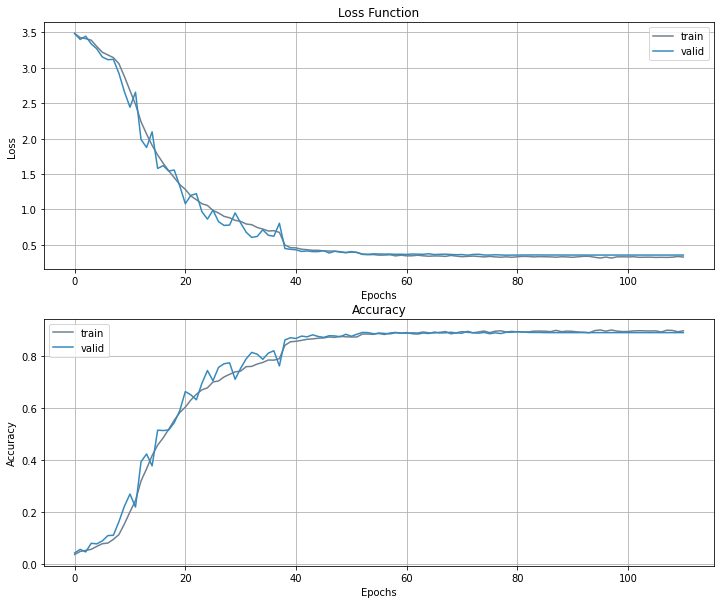

1419/1419 [==============================] - 0s 87us/step


[0.36497379361617055, 0.8837209304425816]

In [0]:
history_plot(history)
gray_model.load_weights(fw)
gray_model.evaluate(x_test2,y_test2)

In [0]:
def gray_model():
    model=Sequential()
    model.add(Conv2D(i32,(i5,i5),padding='same',
                     input_shape=x_train2.shape[i1:]))
    model.add(LeakyReLU(alpha=al))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr))
    model.add(Conv2D(i128,(i5,i5)))
    model.add(LeakyReLU(alpha=al))    
    model.add(MaxPooling2D(pool_size=(i2,i2)))
    model.add(Dropout(dr))   
    model.add(GlobalMaxPooling2D())     
    model.add(Dense(i1024))
    model.add(LeakyReLU(alpha=al)) 
    model.add(Dropout(dr))   
    model.add(Dense(i128))
    model.add(LeakyReLU(alpha=al)) 
    model.add(Dropout(dr))    
    model.add(Dense(i33))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',metrics=['accuracy'])  
    return model
gray_model=gray_model()

In [0]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,
                             save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
estopping=EarlyStopping(monitor='val_loss',patience=i32,verbose=i2)
history=gray_model.fit(x_train2,y_train2,epochs=i200,
                       batch_size=i64,verbose=i2,
                       validation_data=(x_valid2,y_valid2),
                       callbacks=[checkpointer,lr_reduction,estopping])

Train on 11352 samples, validate on 1419 samples
Epoch 1/200
 - 5s - loss: 3.4797 - acc: 0.0369 - val_loss: 3.4210 - val_acc: 0.0479

Epoch 00001: val_loss improved from inf to 3.42098, saving model to weights.letter.hdf5
Epoch 2/200
 - 2s - loss: 3.4185 - acc: 0.0513 - val_loss: 3.4640 - val_acc: 0.0493

Epoch 00002: val_loss did not improve from 3.42098
Epoch 3/200
 - 2s - loss: 3.3600 - acc: 0.0616 - val_loss: 3.3821 - val_acc: 0.0578

Epoch 00003: val_loss improved from 3.42098 to 3.38212, saving model to weights.letter.hdf5
Epoch 4/200
 - 2s - loss: 3.2496 - acc: 0.0668 - val_loss: 3.3269 - val_acc: 0.0613

Epoch 00004: val_loss improved from 3.38212 to 3.32687, saving model to weights.letter.hdf5
Epoch 5/200
 - 2s - loss: 3.2262 - acc: 0.0737 - val_loss: 3.1810 - val_acc: 0.0987

Epoch 00005: val_loss improved from 3.32687 to 3.18096, saving model to weights.letter.hdf5
Epoch 6/200
 - 2s - loss: 3.1785 - acc: 0.0815 - val_loss: 3.3972 - val_acc: 0.0698

Epoch 00006: val_loss did 

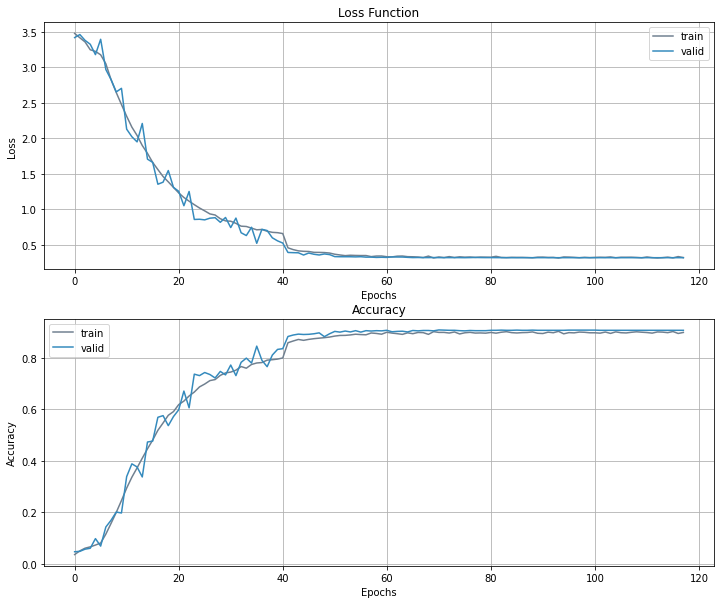

1419/1419 [==============================] - 0s 88us/step


[0.34683093986748975, 0.8858350951374208]

In [0]:
history_plot(history)
gray_model.load_weights(fw)
gray_model.evaluate(x_test2,y_test2)

In [0]:
steps,epochs=int(1000),int(10)
zr,sr,rr=float(.2),float(.2),int(20)
igen=ImageDataGenerator(zoom_range=zr,shear_range=sr,rotation_range=rr)
generator=\
gray_model.fit_generator(igen.flow(x_train2,y_train2,batch_size=i64),
                         steps_per_epoch=steps,epochs=epochs,verbose=i2,
                         validation_data=(x_valid2,y_valid2), 
                         callbacks=[checkpointer,lr_reduction])

Epoch 1/10
 - 17s - loss: 1.2603 - acc: 0.6735 - val_loss: 0.3170 - val_acc: 0.9063

Epoch 00001: val_loss improved from 0.31700 to 0.31700, saving model to weights.letter.hdf5
Epoch 2/10
 - 16s - loss: 1.2443 - acc: 0.6750 - val_loss: 0.3170 - val_acc: 0.9063

Epoch 00002: val_loss improved from 0.31700 to 0.31700, saving model to weights.letter.hdf5
Epoch 3/10
 - 17s - loss: 1.2549 - acc: 0.6722 - val_loss: 0.3170 - val_acc: 0.9063

Epoch 00003: val_loss improved from 0.31700 to 0.31700, saving model to weights.letter.hdf5
Epoch 4/10
 - 17s - loss: 1.2614 - acc: 0.6705 - val_loss: 0.3170 - val_acc: 0.9063

Epoch 00004: val_loss improved from 0.31700 to 0.31700, saving model to weights.letter.hdf5
Epoch 5/10
 - 17s - loss: 1.2520 - acc: 0.6726 - val_loss: 0.3170 - val_acc: 0.9063

Epoch 00005: val_loss improved from 0.31700 to 0.31700, saving model to weights.letter.hdf5
Epoch 6/10
 - 16s - loss: 1.2461 - acc: 0.6735 - val_loss: 0.3170 - val_acc: 0.9063

Epoch 00006: val_loss improved

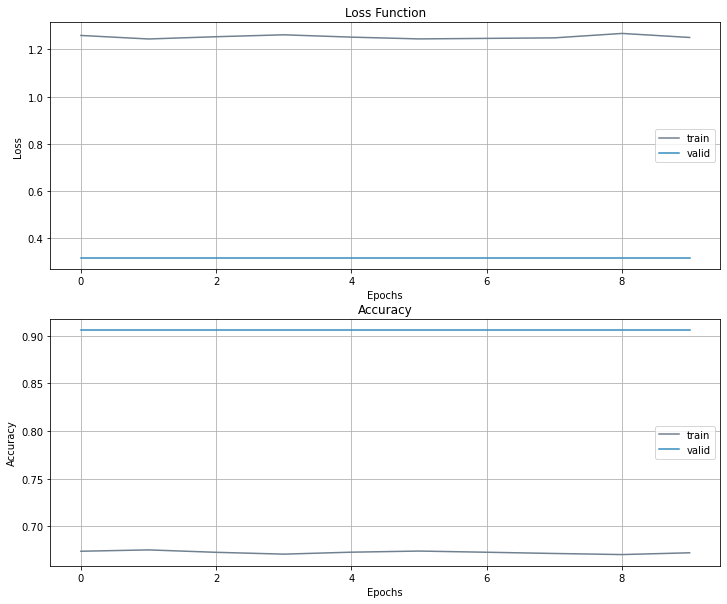

1419/1419 [==============================] - 0s 91us/step


[0.34683109570486265, 0.8858350951374208]

In [0]:
history_plot(generator)
gray_model.load_weights(fw)
gray_model.evaluate(x_test2,y_test2)

In [0]:
cy_train2=np.array([np.argmax(y) for y in y_train2])
cy_test2=np.array([np.argmax(y) for y in y_test2])
cy_valid2=np.array([np.argmax(y) for y in y_valid2])

In [0]:
# clf1=GradientBoostingClassifier()\
# .fit(x_train2.reshape(-1,32*32),cy_train2)
# [clf1.score(x_test2.reshape(-1,32*32),cy_test2),
# clf1.score(x_valid2.reshape(-1,32*32),cy_valid2)]

In [0]:
clf2=RandomForestClassifier()\
.fit(x_train2.reshape(-1,32*32),cy_train2)
[clf2.score(x_test2.reshape(-1,32*32),cy_test2),
 clf2.score(x_valid2.reshape(-1,32*32),cy_valid2)]

[0.3403805496828753, 0.38125440451021847]

## ✒️ &nbsp; Step 3. Multi-Label Classification Models
#### Color Images

In [0]:
def multi_model():    
    model_input=Input(shape=(i32,i32,i3))
    x=BatchNormalization()(model_input)
    x=Conv2D(i32,(i3,i3),padding='same')(model_input)
    x=LeakyReLU(alpha=al)(x)
    x=MaxPooling2D(pool_size=(i2,i2))(x)    
    x=Dropout(dr)(x)   
    x=Conv2D(i128,(i3,i3),padding='same')(x)
    x=LeakyReLU(alpha=al)(x)
    x=MaxPooling2D(pool_size=(i2,i2))(x)    
    x=Dropout(dr)(x)             
    x=GlobalMaxPooling2D()(x)   
    x=Dense(i1024)(x)
    x=LeakyReLU(alpha=al)(x)
    x=Dropout(dr)(x)   
    x=Dense(i128)(x)  
    x=LeakyReLU(alpha=al)(x)
    x=Dropout(dr)(x)    
    y1=Dense(i33,activation='softmax')(x)
    y2=Dense(i4,activation='softmax')(x)    
    model=Model(inputs=model_input,outputs=[y1,y2])
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])
    return model
multi_model=multi_model()
multi_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_31 (LeakyReLU)      (None, 32, 32, 32)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 16, 16, 32)   0           leaky_re_lu_31[0][0]             
____________________________________________________________________________________________

In [0]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,
                             save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
history=multi_model.fit(x_train3,[y_train3[:,:i33],y_train3[:,i33:]],
                        epochs=i100,batch_size=i64,verbose=i2,
                        validation_data=(x_valid3,
                                         [y_valid3[:,:i33],
                                          y_valid3[:,i33:]]),
                        callbacks=[checkpointer,lr_reduction])

Train on 11352 samples, validate on 1419 samples
Epoch 1/100
 - 6s - loss: 4.5287 - dense_42_loss: 3.5066 - dense_43_loss: 1.0221 - dense_42_acc: 0.0301 - dense_43_acc: 0.5579 - val_loss: 4.3267 - val_dense_42_loss: 3.4687 - val_dense_43_loss: 0.8580 - val_dense_42_acc: 0.0282 - val_dense_43_acc: 0.7632

Epoch 00001: val_loss improved from inf to 4.32667, saving model to weights.letter.hdf5
Epoch 2/100
 - 2s - loss: 4.3384 - dense_42_loss: 3.4359 - dense_43_loss: 0.9024 - dense_42_acc: 0.0496 - dense_43_acc: 0.6598 - val_loss: 4.1287 - val_dense_42_loss: 3.4129 - val_dense_43_loss: 0.7157 - val_dense_42_acc: 0.0648 - val_dense_43_acc: 0.7505

Epoch 00002: val_loss improved from 4.32667 to 4.12867, saving model to weights.letter.hdf5
Epoch 3/100
 - 2s - loss: 4.1292 - dense_42_loss: 3.3246 - dense_43_loss: 0.8046 - dense_42_acc: 0.0652 - dense_43_acc: 0.6997 - val_loss: 4.8286 - val_dense_42_loss: 3.4104 - val_dense_43_loss: 1.4182 - val_dense_42_acc: 0.0571 - val_dense_43_acc: 0.4489



In [0]:
multi_model.evaluate(x_test3,\
[y_test3[:,:i33],y_test3[:,i33:]])

1419/1419 [==============================] - 0s 103us/step


[2.7726701440065153,
 2.691397988182966,
 0.08127216191898698,
 0.19661733619422456,
 0.9739252995066948]

#### Grayscale Images

In [0]:
def gray_multi_model():    
    model_input=Input(shape=(i32,i32,i1))
    x=BatchNormalization()(model_input)
    x=Conv2D(i32,(i5,i5),padding='same')(model_input)
    x=LeakyReLU(alpha=al)(x)
    x=MaxPooling2D(pool_size=(i2,i2))(x)    
    x=Dropout(dr)(x)   
    x=Conv2D(i256,(i5,i5),padding='same')(x) 
    x=LeakyReLU(alpha=al)(x)
    x=MaxPooling2D(pool_size=(i2,i2))(x)    
    x=Dropout(dr)(x)             
    x=GlobalMaxPooling2D()(x)    
    x=Dense(i1024)(x) 
    x=LeakyReLU(alpha=al)(x)
    x=Dropout(dr)(x)   
    x=Dense(i256)(x) 
    x=LeakyReLU(alpha=al)(x)
    x=Dropout(dr)(x)   
    y1=Dense(i33,activation='softmax')(x)
    y2=Dense(i4,activation='softmax')(x)      
    model=Model(inputs=model_input,outputs=[y1,y2])
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',metrics=['accuracy'])      
    return model
gray_multi_model=gray_multi_model()

In [0]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=i2,
                             save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=i5,
                               verbose=i2,factor=fr)
history=gray_multi_model.fit(x_train4,[y_train4[:,:i33],y_train4[:,i33:]], 
                             validation_data=(x_valid4,
                                              [y_valid4[:,:i33],
                                               y_valid4[:,i33:]],), 
                             epochs=i200,batch_size=i128,verbose=i2, 
                             callbacks=[checkpointer,lr_reduction])

Train on 11352 samples, validate on 1419 samples
Epoch 1/200
 - 6s - loss: 4.5875 - dense_46_loss: 3.5075 - dense_47_loss: 1.0800 - dense_46_acc: 0.0285 - dense_47_acc: 0.4728 - val_loss: 4.5717 - val_dense_46_loss: 3.4962 - val_dense_47_loss: 1.0756 - val_dense_46_acc: 0.0331 - val_dense_47_acc: 0.4221

Epoch 00001: val_loss improved from inf to 4.57174, saving model to weights.letter.hdf5
Epoch 2/200
 - 2s - loss: 4.4656 - dense_46_loss: 3.4912 - dense_47_loss: 0.9744 - dense_46_acc: 0.0361 - dense_47_acc: 0.5676 - val_loss: 4.5361 - val_dense_46_loss: 3.4769 - val_dense_47_loss: 1.0592 - val_dense_46_acc: 0.0465 - val_dense_47_acc: 0.5130

Epoch 00002: val_loss improved from 4.57174 to 4.53613, saving model to weights.letter.hdf5
Epoch 3/200
 - 2s - loss: 4.1293 - dense_46_loss: 3.4162 - dense_47_loss: 0.7131 - dense_46_acc: 0.0466 - dense_47_acc: 0.7445 - val_loss: 4.1680 - val_dense_46_loss: 3.3680 - val_dense_47_loss: 0.8001 - val_dense_46_acc: 0.0507 - val_dense_47_acc: 0.6413



In [0]:
gray_multi_model.evaluate(x_test4,\
[y_test4[:,:i33],y_test4[:,i33:]])

1419/1419 [==============================] - 0s 135us/step


[0.38498710611489895,
 0.3513633043645048,
 0.03362380103695419,
 0.8851303737124899,
 0.9866102889358703]

## ✒️ &nbsp; Step 4. Keras Applications

In [0]:
from keras.applications.vgg16 import VGG16,preprocess_input as prei16
from skimage.transform import resize
def resh(x,n):
    y=[resize(el,(int(n),int(n),int(3)),
              anti_aliasing=True) for el in x]
    return np.array(y)

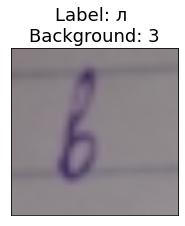

In [0]:
img=resh(images[100].reshape(1,32,32,3),128).reshape(128,128,3)
pl.figure(figsize=(3,4)); il=10**4
pl.xticks([]); pl.yticks([])
pl.title('Label: %s \n'%letters[labels[il]-1]+\
         'Background: %s'%backgrounds[il],
         fontsize=18)
pl.imshow(img); pl.show()

In [0]:
#vx_train1,vx_valid1,vx_test1=\
#resh(x_train1,128),resh(x_valid1,128),resh(x_test1,128)
#vx_train1,vx_valid1,vx_test1=\
#prei16(x_train1),prei16(x_valid1),prei16(x_test1)
vgg16bmodel=VGG16(weights='imagenet',include_top=False)
pvx_train1=vgg16bmodel.predict(x_train1)
pvx_valid1=vgg16bmodel.predict(x_valid1)
pvx_test1=vgg16bmodel.predict(x_test1)
pvx_train1=pvx_train1.reshape(-1,1,1,pvx_train1.shape[3])
pvx_valid1=pvx_valid1.reshape(-1,1,1,pvx_valid1.shape[3])
pvx_test1=pvx_test1.reshape(-1,1,1,pvx_test1.shape[3])

In [0]:
#np.save('vx_train1.npy',vx_train1)
#np.save('vx_valid1.npy',vx_valid1)
#np.save('vx_test1.npy',vx_test1)
#vx_train1=np.load('vx_train_1.npy')
#vx_valid1=np.load('vx_valid1.npy')
#vx_test1=np.load('vx_test1.npy')

In [0]:
sh=pvx_train1.shape[1:]
def vgg16model():
    model=Sequential()  
    model.add(GlobalAveragePooling2D(input_shape=sh))   
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))        
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))  
#    model.add(Dense(128))
#    model.add(LeakyReLU(alpha=.02))
#    model.add(Dropout(.25)) 
    model.add(Dense(33,activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])
    return model
vgg16model=vgg16model()

In [0]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.8)
estopping=EarlyStopping(monitor='val_loss',patience=30,verbose=2)
history=vgg16model.fit(pvx_train1,y_train1, 
                       validation_data=(pvx_valid1,y_valid1), 
                       epochs=800,batch_size=128,verbose=2, 
                       callbacks=[checkpointer,lr_reduction,estopping])

Train on 11352 samples, validate on 1419 samples
Epoch 1/800
 - 5s - loss: 3.0101 - acc: 0.1452 - val_loss: 2.6811 - val_acc: 0.2044

Epoch 00001: val_loss improved from inf to 2.68108, saving model to weights.letter.hdf5
Epoch 2/800
 - 1s - loss: 2.3396 - acc: 0.2884 - val_loss: 2.2322 - val_acc: 0.3143

Epoch 00002: val_loss improved from 2.68108 to 2.23225, saving model to weights.letter.hdf5
Epoch 3/800
 - 1s - loss: 2.0497 - acc: 0.3652 - val_loss: 1.9347 - val_acc: 0.3996

Epoch 00003: val_loss improved from 2.23225 to 1.93474, saving model to weights.letter.hdf5
Epoch 4/800
 - 1s - loss: 1.8652 - acc: 0.4217 - val_loss: 1.7620 - val_acc: 0.4538

Epoch 00004: val_loss improved from 1.93474 to 1.76204, saving model to weights.letter.hdf5
Epoch 5/800
 - 1s - loss: 1.7452 - acc: 0.4533 - val_loss: 1.8145 - val_acc: 0.4475

Epoch 00005: val_loss did not improve from 1.76204
Epoch 6/800
 - 1s - loss: 1.6378 - acc: 0.4885 - val_loss: 1.6613 - val_acc: 0.4834

Epoch 00006: val_loss impr

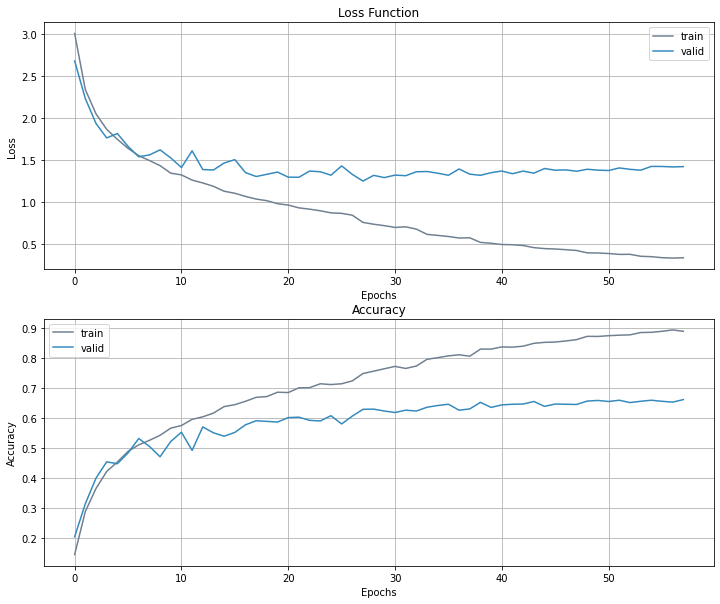

1419/1419 [==============================] - 0s 69us/step


[1.3538532339409257, 0.6215644821976171]

In [0]:
history_plot(history)
vgg16model.load_weights(fw)
vgg16model.evaluate(pvx_test1,y_test1)

In [0]:
from keras.applications.vgg19 import VGG19,preprocess_input as prei19
#vx_train1,vx_valid1,vx_test1=\
#resh(x_train1),resh(x_valid1),resh(x_test1)
#vx_train1,vx_valid1,vx_test1=\
#prei19(x_train1),prei19(x_valid1),prei19(x_test1)
vgg19bmodel=VGG19(weights='imagenet',include_top=False)
pvx_train1=vgg19bmodel.predict(x_train1)
pvx_valid1=vgg19bmodel.predict(x_valid1)
pvx_test1=vgg19bmodel.predict(x_test1)
pvx_train1=pvx_train1.reshape(-1,1,1,pvx_train1.shape[3])
pvx_valid1=pvx_valid1.reshape(-1,1,1,pvx_valid1.shape[3])
pvx_test1=pvx_test1.reshape(-1,1,1,pvx_test1.shape[3])

In [0]:
sh=pvx_train1.shape[1:]
def vgg19model():
    model=Sequential()  
    model.add(GlobalAveragePooling2D(input_shape=sh))   
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))        
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))  
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25)) 
    model.add(Dense(33,activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])
    return model
vgg19model=vgg19model()

In [0]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.8)
estopping=EarlyStopping(monitor='val_loss',patience=30,verbose=2)
history=vgg19model.fit(pvx_train1,y_train1, 
                       validation_data=(pvx_valid1,y_valid1), 
                       epochs=800,batch_size=128,verbose=2, 
                       callbacks=[checkpointer,lr_reduction,estopping])

Train on 11352 samples, validate on 1419 samples
Epoch 1/800
 - 5s - loss: 3.3642 - acc: 0.0671 - val_loss: 3.0956 - val_acc: 0.1106

Epoch 00001: val_loss improved from inf to 3.09564, saving model to weights.letter.hdf5
Epoch 2/800
 - 1s - loss: 2.9809 - acc: 0.1410 - val_loss: 2.7622 - val_acc: 0.1846

Epoch 00002: val_loss improved from 3.09564 to 2.76219, saving model to weights.letter.hdf5
Epoch 3/800
 - 1s - loss: 2.6847 - acc: 0.2009 - val_loss: 2.4895 - val_acc: 0.2382

Epoch 00003: val_loss improved from 2.76219 to 2.48954, saving model to weights.letter.hdf5
Epoch 4/800
 - 1s - loss: 2.4897 - acc: 0.2460 - val_loss: 2.2566 - val_acc: 0.3037

Epoch 00004: val_loss improved from 2.48954 to 2.25662, saving model to weights.letter.hdf5
Epoch 5/800
 - 1s - loss: 2.3466 - acc: 0.2822 - val_loss: 2.2378 - val_acc: 0.3319

Epoch 00005: val_loss improved from 2.25662 to 2.23783, saving model to weights.letter.hdf5
Epoch 6/800
 - 1s - loss: 2.2803 - acc: 0.3072 - val_loss: 2.1802 - va

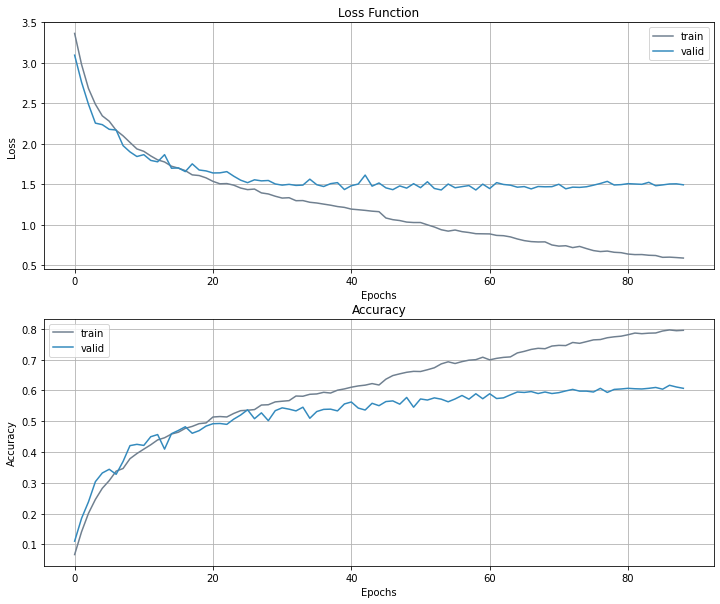

1419/1419 [==============================] - 0s 67us/step


[1.5808544846132155, 0.5623678646094368]

In [0]:
history_plot(history)
vgg19model.load_weights(fw)
vgg19model.evaluate(pvx_test1,y_test1)

In [0]:
from keras.applications.resnet_v2 import ResNet152V2,preprocess_input as preiRN
#vx_train1,vx_valid1,vx_test1=\
#preiRN(x_train1),preiRN(x_valid1),preiRN(x_test1)
RNbmodel=ResNet152V2(weights='imagenet',include_top=False)
pvx_train1=RNbmodel.predict(x_train1)
pvx_valid1=RNbmodel.predict(x_valid1)
pvx_test1=RNbmodel.predict(x_test1)
pvx_train1=pvx_train1.reshape(-1,1,1,pvx_train1.shape[3])
pvx_valid1=pvx_valid1.reshape(-1,1,1,pvx_valid1.shape[3])
pvx_test1=pvx_test1.reshape(-1,1,1,pvx_test1.shape[3])

In [0]:
sh=pvx_train1.shape[1:]
def RNmodel():
    model=Sequential()  
    model.add(GlobalAveragePooling2D(input_shape=sh))   
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25)) 
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))        
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))   
    model.add(Dense(33,activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])
    return model
RNmodel=RNmodel()

In [0]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=30,verbose=2)
history=RNmodel.fit(pvx_train1,y_train1, 
                    validation_data=(pvx_valid1,y_valid1), 
                    epochs=800,batch_size=128,verbose=2, 
                    callbacks=[checkpointer,lr_reduction,estopping])

Train on 11352 samples, validate on 1419 samples
Epoch 1/800
 - 8s - loss: 3.1298 - acc: 0.1278 - val_loss: 2.7770 - val_acc: 0.1959

Epoch 00001: val_loss improved from inf to 2.77704, saving model to weights.letter.hdf5
Epoch 2/800
 - 1s - loss: 2.7204 - acc: 0.2144 - val_loss: 2.6169 - val_acc: 0.2502

Epoch 00002: val_loss improved from 2.77704 to 2.61688, saving model to weights.letter.hdf5
Epoch 3/800
 - 1s - loss: 2.5121 - acc: 0.2630 - val_loss: 2.4988 - val_acc: 0.2685

Epoch 00003: val_loss improved from 2.61688 to 2.49877, saving model to weights.letter.hdf5
Epoch 4/800
 - 1s - loss: 2.3599 - acc: 0.2999 - val_loss: 2.3984 - val_acc: 0.3044

Epoch 00004: val_loss improved from 2.49877 to 2.39844, saving model to weights.letter.hdf5
Epoch 5/800
 - 1s - loss: 2.2301 - acc: 0.3356 - val_loss: 2.3186 - val_acc: 0.3178

Epoch 00005: val_loss improved from 2.39844 to 2.31861, saving model to weights.letter.hdf5
Epoch 6/800
 - 1s - loss: 2.1108 - acc: 0.3686 - val_loss: 2.3597 - va

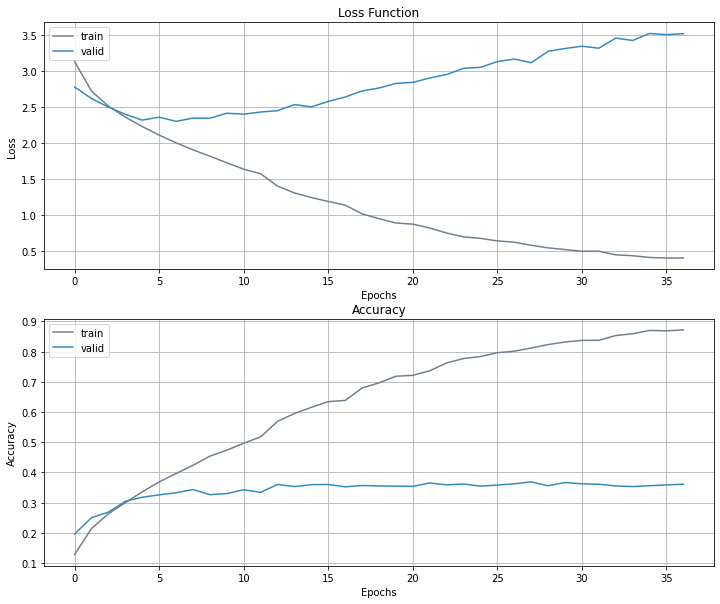

1419/1419 [==============================] - 0s 96us/step


[2.4172107299672962, 0.2973925300136765]

In [0]:
history_plot(history)
RNmodel.load_weights(fw)
RNmodel.evaluate(pvx_test1,y_test1)

In [0]:
from keras.applications.nasnet import NASNetLarge
NNLbmodel=NASNetLarge(weights='imagenet',include_top=False)
n1,n2=1800,180
def resh(x):
    y=[resize(el,(int(331),int(331),int(3)),
              anti_aliasing=True) for el in x]
    return np.array(y)
pvx_train1,pvx_valid1,pvx_test1=\
resh(x_train1[:n1]),resh(x_valid1[:n2]),resh(x_test1[:n2])
pvx_train1=NNLbmodel.predict(pvx_train1)
pvx_valid1=NNLbmodel.predict(pvx_valid1)
pvx_test1=NNLbmodel.predict(pvx_test1)

In [0]:
pvx_train1.shape

(1800, 11, 11, 4032)

In [0]:
sh=pvx_train1.shape[1:]
def NNLmodel():
    model=Sequential()  
    model.add(GlobalAveragePooling2D(input_shape=sh))   
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25)) 
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))        
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))   
    model.add(Dense(33,activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])
    return model
NNLmodel=NNLmodel()

In [0]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.8)
estopping=EarlyStopping(monitor='val_loss',patience=30,verbose=2)
history=NNLmodel.fit(pvx_train1,y_train1[:n1], 
                     validation_data=(pvx_valid1,y_valid1[:n2]), 
                     epochs=800,batch_size=128,verbose=2, 
                     callbacks=[checkpointer,lr_reduction,estopping])

Train on 1800 samples, validate on 180 samples
Epoch 1/800
 - 11s - loss: 3.5950 - acc: 0.0528 - val_loss: 3.3665 - val_acc: 0.0611

Epoch 00001: val_loss improved from inf to 3.36648, saving model to weights.letter.hdf5
Epoch 2/800
 - 2s - loss: 3.2763 - acc: 0.0989 - val_loss: 3.2579 - val_acc: 0.1167

Epoch 00002: val_loss improved from 3.36648 to 3.25788, saving model to weights.letter.hdf5
Epoch 3/800
 - 2s - loss: 3.0534 - acc: 0.1400 - val_loss: 3.0346 - val_acc: 0.1667

Epoch 00003: val_loss improved from 3.25788 to 3.03455, saving model to weights.letter.hdf5
Epoch 4/800
 - 2s - loss: 2.8803 - acc: 0.1711 - val_loss: 2.9398 - val_acc: 0.1889

Epoch 00004: val_loss improved from 3.03455 to 2.93978, saving model to weights.letter.hdf5
Epoch 5/800
 - 2s - loss: 2.6869 - acc: 0.2094 - val_loss: 2.8088 - val_acc: 0.1778

Epoch 00005: val_loss improved from 2.93978 to 2.80881, saving model to weights.letter.hdf5
Epoch 6/800
 - 2s - loss: 2.4655 - acc: 0.2656 - val_loss: 2.8469 - val

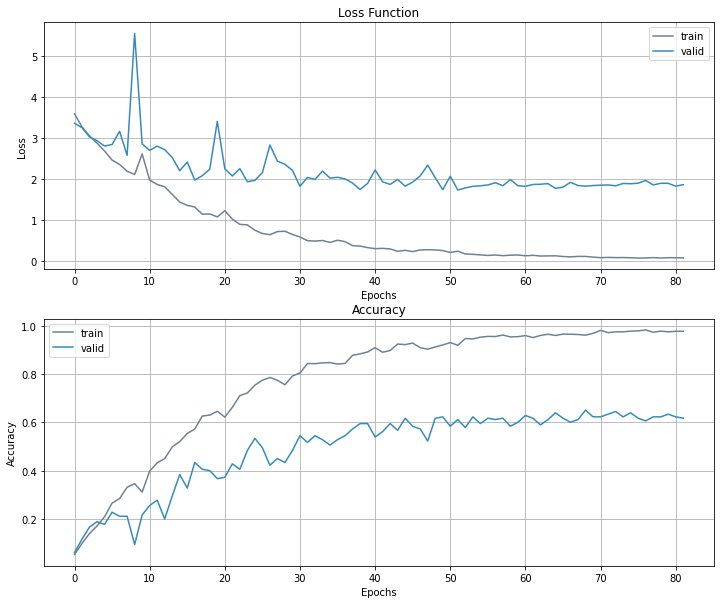

180/180 [==============================] - 0s 1ms/step


[2.3467344601949054, 0.49999999867545236]

In [0]:
history_plot(history)
NNLmodel.load_weights(fw)
NNLmodel.evaluate(pvx_test1,y_test1[:n2])

In [0]:
del pvx_train1,pvx_valid1,pvx_test1